## Librairies :

In [1]:
from scipy.spatial import Voronoi, voronoi_plot_2d,ConvexHull
import numpy as np
import matplotlib.pyplot as plt
import DCCA 
import pandas as pd
from datetime import datetime as dt
import math

## Lecture des fichiers :

In [2]:

"""
Préparation du dataset   
fichier = open("BS_Locations/Lille_antenna_location.csv",'r')
fichier2 = open("BS_Locations/Lille_antenna_location2.csv",'w')        # On rajoute un tilde à la fin pour éviter d'écraser le fichier source en cas de bug
lignes = fichier.readlines()                # On parcours les lignes du fichier source
for ligne in lignes:
    ligneFinale = ligne.replace(';',', ')            # On remplace tout les espaces par groupe de 4 en tabulation
    fichier2.write(ligneFinale)             # On écrit la nouvelle ligne dans le nouveau fichier
                 
fichier.close()                     # Fermeture du fichier source
fichier2.close()    
"""       
df_geo=pd.read_csv("BS_Locations/Lille_antenna_location2.csv")

df_geo_norm=DCCA.normalize_distance(df_geo) #a que les deux colonnes X et Y sans ID

#Avec les heures 
"""
fichier = open("data/Lille/Lille.csv",'r')
fichier2 = open("data/Lille/Lille_traite.csv",'w')        # On rajoute un tilde à la fin pour éviter d'écraser le fichier source en cas de bug
lignes = fichier.readlines()                # On parcours les lignes du fichier source
for ligne in lignes:
    ligneFinale = ligne.replace(';',', ')            # On remplace tout les espaces par groupe de 4 en tabulation
    fichier2.write(ligneFinale) 
fichier.close()                     # Fermeture du fichier source
fichier2.close()
"""
df_traffic=pd.read_csv("data/Lille/Lille_traite.csv")



## Récupération des positions uniques et les ids par position

In [3]:
##### les coordonnées sans doublons
coord=[]
id_per_coord={}
for c in range(len(df_geo)):
    x=(df_geo.iloc[c]).iloc[1]
    y=(df_geo.iloc[c]).iloc[2]
    if(not [x,y] in coord):
        coord.append([x,y])
        id_per_coord[(x,y)]=[(df_geo.iloc[c]).iloc[0]]
    else:
        id_per_coord[(x,y)].append((df_geo.iloc[c]).iloc[0])
Nr=len(coord)
print(id_per_coord[(coord[0][0],coord[0][1])])


['0102f81000655dd0', '0102f8100065d1c4', '0102f81000658c0b', '0102f8100065eb38', '8102f8100001484a', '0102f8100065a56e']


## Le trafic max et min

In [4]:
trafic_max=df_traffic[' ByteDn'].max()
trafic_min=df_traffic[' ByteDn'].min()
print("Trafic_max :",trafic_max)
print("Trafic_min :",trafic_min)

Trafic_max : 15828358767.955057
Trafic_min : 0.0


## Le trafic par jour :

In [5]:
traffic_per_day={}
for t in range(len(df_traffic)):
    day=(df_traffic[' TimeSlot'][t])[1:11]
    if (not day in traffic_per_day.keys()):
        traffic_per_day[day]=df_traffic.loc[df_traffic[' TimeSlot'].str.contains(day)]

In [6]:
for d in traffic_per_day.keys():
    print(d,np.size(traffic_per_day[d]['CellID'].unique()))

2019-03-19 760
2019-03-20 762
2019-03-21 760
2019-03-22 764
2019-03-25 763
2019-03-26 768
2019-03-27 771
2019-03-28 772
2019-03-29 776
2019-03-30 775
2019-04-01 774
2019-04-03 773
2019-04-04 776
2019-04-05 775
2019-04-22 766
2019-04-23 767
2019-04-24 767
2019-04-25 769
2019-04-26 775
2019-04-29 767
2019-04-30 768
2019-03-16 757
2019-03-17 753
2019-05-01 754
2019-05-02 763
2019-05-03 767
2019-05-04 764
2019-05-05 760
2019-05-06 765
2019-05-07 775
2019-05-08 774
2019-05-09 779
2019-05-11 766
2019-05-12 771
2019-05-13 778
2019-05-16 779
2019-05-17 779
2019-05-18 764
2019-05-26 774
2019-05-27 778
2019-05-29 779
2019-06-03 776
2019-06-04 774
2019-06-05 772
2019-06-06 774
2019-06-07 772
2019-06-12 773
2019-06-13 774
2019-06-14 777
2019-06-15 775
2019-03-18 760
2019-03-24 760
2019-04-07 772
2019-04-13 772
2019-04-14 772
2019-04-20 771
2019-04-21 764
2019-04-28 361
2019-04-15 776
2019-04-16 776
2019-04-17 776
2019-04-18 776
2019-04-19 776
2019-03-31 772
2019-04-02 772
2019-04-06 775
2019-05-19

## Déclaration des variables globales :

In [6]:
dt=1  #DeltaT = 1heure
Nt=int(24/dt)  #nombre de timespan  par jour
NBBU=2
CBBU=1
To=0.04
max_iter=20
iter_converge=6

## Génération de la matrice F de trafic pour 24h:

In [7]:
def generate_day_matrix(day):
    #Nr=df_geo_norm.count()[0]  #nombre des RRHs
    train_traffic=traffic_per_day[day]
    RRH_ID=train_traffic['CellID'].unique()
    #Nr=np.size(RRH_ID)  # nbre de RRH dans données trafic < nbre RRHs dans geo données
    r=[]
    F=np.empty([Nr,Nt])
    Fup=np.empty([Nr,Nt])
    for i in range (Nr) :
        #id=RRH_ID[i]
        lesids=id_per_coord[(coord[i][0],coord[i][1])]
        trafic_RRH =[]
        for id in lesids:
            trafic_RRH +=[train_traffic.loc[train_traffic['CellID']==id,:]]
        trafic_RRH=pd.concat(trafic_RRH,axis=0)
        for h in range(Nt):
            #print(     "H= ",h,"/24")
            if (h <10):
                sh='0'+str(h)
            else:
                sh=str(h)
            tu=0
            td=0
            nbr=0
            j=0
            for ind in (trafic_RRH.index.values):
                slot=trafic_RRH.iloc[j]
                if(slot[' TimeSlot'][12:14] == sh):
                    trafic_RRH=trafic_RRH.drop([ind])
                    nbr+=1
                    td+=slot[' ByteDn']
                    tu+=slot[' ByteUp'] 
                else:
                    j+=1
            if(nbr >0):
                F[i][h]=td/nbr
                Fup[i][h]=tu/nbr 
            else :
                F[i][h]=td
                Fup[i][h]=tu
        r.append(DCCA.RRH(lesids[0],i,df_geo_norm.iloc[i,0],df_geo_norm.iloc[i,1],F[i]))
    return F,Fup,r

In [100]:
#F,Fup,r=generate_day_matrix("2019-03-19")

## Application de DCCA :

In [8]:
def apply_DCCA(F_norm,r,To,CBBU):
    T=DCCA.peak_tracking(CBBU,F_norm,r)  
    W=DCCA.matriceComplementarite(r,CBBU,To)
    P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
    return P,l

In [49]:
"""
print(df_geo.head(4))
print(df_geo_norm.iloc[3,0])
print(df_geo.iloc[3,0])
print(df_geo.loc[df_geo['LocInfo']=="0102f81000655dd0",:])
(df_geo.loc[df_geo['LocInfo']=="0102f81000655dd0",:]).iloc[0,1]
"""

'\nprint(df_geo.head(4))\nprint(df_geo_norm.iloc[3,0])\nprint(df_geo.iloc[3,0])\nprint(df_geo.loc[df_geo[\'LocInfo\']=="0102f81000655dd0",:])\n(df_geo.loc[df_geo[\'LocInfo\']=="0102f81000655dd0",:]).iloc[0,1]\n'

In [50]:
"""
lescomp=np.array(lescomp)
print("K =",k,"\n",
      "max :",np.max(lescomp),"\n",
      "min :",np.min(lescomp),"\n",
      "moyenne :",np.mean(lescomp),"\n",
      "mediane :",np.median(lescomp),)
#plt.hist(lescomp,bins='auto')
"""

'\nlescomp=np.array(lescomp)\nprint("K =",k,"\n",\n      "max :",np.max(lescomp),"\n",\n      "min :",np.min(lescomp),"\n",\n      "moyenne :",np.mean(lescomp),"\n",\n      "mediane :",np.median(lescomp),)\n#plt.hist(lescomp,bins=\'auto\')\n'

## Affichage simple des clusters :

In [9]:
""" affichage des clusters """
def display_cluster(P):
    k=0
    lescomp=[]
    plt.title("Clustering DCCA, To =0.24")
    coord_X=[]
    coord_Y=[]
    coord2=[]
    clusters=[]
    for C in P:
        if (C!=[]):
            k+=1
            lescomp.append(DCCA.complementarity(C,CBBU))
            X=np.empty([len(C),2])
            for i in range(len(C)):
                ligne=df_geo.loc[df_geo['LocInfo']==C[i].id,:]
                x=ligne.iloc[0,1]
                y=ligne.iloc[0,2]
                X[i][0]=x
                X[i][1]=y
                coord_X.append(x)
                coord_Y.append(y)
                if(not [x,y] in coord2):
                    coord2.append([x,y])
                clusters.append(k)
            plt.scatter(X[:,0],X[:,1])
    return coord2,clusters,k

## Affichage des clusters avec voronoi :

In [10]:
from scipy.spatial import Voronoi, voronoi_plot_2d,ConvexHull
from matplotlib import cm
import matplotlib as mpl
import random
import colorsys
def colors1(n):
    ret = []
    r = int(random.random() * 256)
    g = int(random.random() * 256)
    b = int(random.random() * 256)
    step = 256 / n
    for i in range(n):
        r += step
        g += step
        b += step
        r = int(r) % 256
        g = int(g) % 256
        b = int(b) % 256
        ret.append((r/256,g/265,b/256)) 
    return ret
def colors(N):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(N)]
    return color



def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
        
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def affichage_vor(P,coord,col,title): 
    vor = Voronoi(coord)
    fig=voronoi_plot_2d(vor, show_points=True, show_vertices=False, s=1,line_colors='white',line_width=0.5, line_alpha=0.3)
    regions, vertices = voronoi_finite_polygons_2d(vor)
    r=0
    for region in regions:
        polygon = vertices[region]
        plt.fill(*zip(*polygon), color=col[clusters[r]-1]) 
        r+=1
    fig.suptitle(title)
    plt.show()

   

In [20]:
"""
viridis = cm.get_cmap('viridis', 12)
color=cm.rainbow(np.linspace(0,1,10))
cm.get_cmap('hsv', 10)
print(color)
"""

[[5.00000000e-01 0.00000000e+00 1.00000000e+00 1.00000000e+00]
 [2.80392157e-01 3.38158275e-01 9.85162233e-01 1.00000000e+00]
 [6.07843137e-02 6.36474236e-01 9.41089253e-01 1.00000000e+00]
 [1.66666667e-01 8.66025404e-01 8.66025404e-01 1.00000000e+00]
 [3.86274510e-01 9.84086337e-01 7.67362681e-01 1.00000000e+00]
 [6.13725490e-01 9.84086337e-01 6.41213315e-01 1.00000000e+00]
 [8.33333333e-01 8.66025404e-01 5.00000000e-01 1.00000000e+00]
 [1.00000000e+00 6.36474236e-01 3.38158275e-01 1.00000000e+00]
 [1.00000000e+00 3.38158275e-01 1.71625679e-01 1.00000000e+00]
 [1.00000000e+00 1.22464680e-16 6.12323400e-17 1.00000000e+00]]


## Tests :

### DCCA avec 24 timespan 

In [16]:
color=colors(60)
general_color=color

In [11]:
F,Fup,r=generate_day_matrix("2019-05-21")

In [12]:
trafic_max0=np.max(F)*0.75
trafic_min0=np.min(F)*0.75
F_norm=DCCA.normalize_trafic(F,trafic_max0,trafic_min0)
for i in range(len(r)):
        r[i].setTrafic(F_norm[i])

14


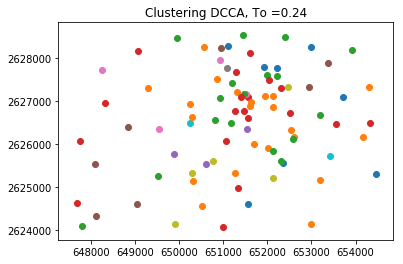

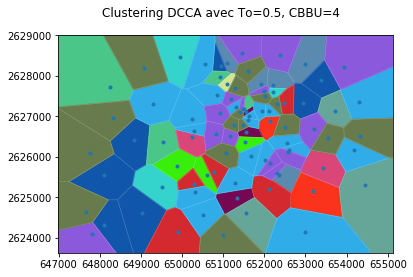

In [20]:
NBBU=2
CBBU=4
To=0.5
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
#color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.5, CBBU=4")

In [18]:
def gain(P,cbbu):
    maxgain=0
    mingain=100000
    gains=[]
    for c in P:
        if c!=[]:
            agg=DCCA.aggregationTrafic(c)
            g=max(agg)/cbbu
            gains.append(g)
            if (g>maxgain):
                maxgain=g
            if(g<mingain):
                mingain=g
    moygain=np.mean(np.array(gains))
    return maxgain,mingain,moygain
    

In [25]:
print(gain(P,CBBU))

(1.328996691110131, 0.08410964026927144, 0.3808676350246238)


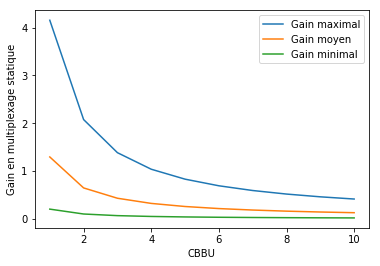

In [21]:
To=0.5
bbus=[]
gmax=[]
gmin=[]
gmoy=[]
for bbu in range(1,11):
    bbus.append(bbu)
    #W=DCCA.matriceComplementarite(r,bbu,To)
    #P,l=DCCA.iterative_DCCA (r,F_norm,bbu,max_iter,To,iter_converge)
    x,n,m=gain(P,bbu)
    gmax.append(x)
    gmin.append(n)
    gmoy.append(m)
plt.plot(bbus,gmax,label="Gain maximal")
plt.plot(bbus,gmoy,label="Gain moyen")
plt.plot(bbus,gmin,label="Gain minimal")
plt.legend()
plt.ylabel("Gain en multiplexage statique")
plt.xlabel("CBBU")
plt.show()

#### Valeur de To:

In [94]:
SMG={}
SMGmax={}
SMGmin={}
SMGmoy={}
surcharge={}
surcharge_moy={}
souscharge={}
souscharge_moy={}
utilite_max={}
utilite_moy={}

57


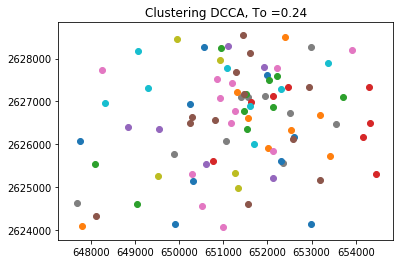

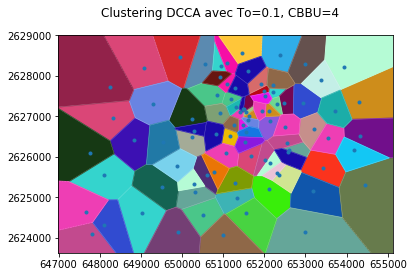

In [95]:
NBBU=2
CBBU=4
To=0.1
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
#color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.1, CBBU=4")

In [96]:
SMG[To]=(len(clusters)/(k*CBBU))
x,n,y=gain(P,CBBU)
SMGmax[To]=x
SMGmin[To]=n
SMGmoy[To]=y
ecartpos=[]
ecartneg=[]
utilite=[]
for c in P:
    if c!=[]:
        agg=DCCA.aggregationTrafic(c)
        ecart=CBBU-np.max(agg)
        utilite.append(np.max(agg))
        if (ecart >=0):
            ecartpos.append(ecart)
        else:
            ecartneg.append(abs(ecart))
utilite_moy[To]=np.mean(np.array(utilite))            
if(ecartpos != []):
    souscharge[To]=max(ecartpos)
    souscharge_moy[To]=np.mean(np.array(ecartpos))
else:
    souscharge[To]=0
    souscharge_moy[To]=0
if(ecartneg != []):
    surcharge[To]=max(ecartneg)
    surcharge_moy[To]=np.mean(np.array(ecartneg))
    utilite_max[To]=CBBU+max(ecartneg)
else:
    surcharge[To]=0
    surcharge_moy[To]=0
    utilite_max[To]=CBBU-min(ecartpos)

        

32


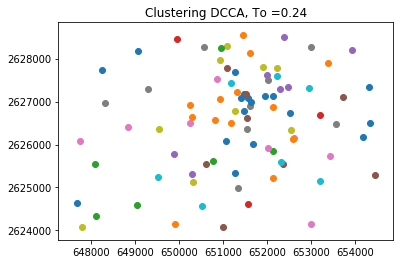

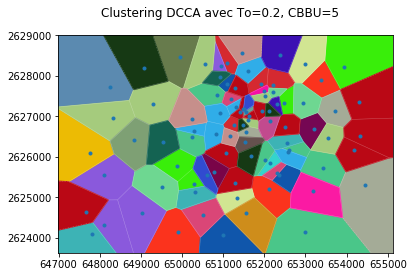

In [97]:
To=0.2
#P,l=apply_DCCA(F,r,To,CBBU)

#T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
#color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.2, CBBU=5")

In [98]:
SMG[To]=(len(clusters)/(k*CBBU))
x,n,y=gain(P,CBBU)
SMGmax[To]=x
SMGmin[To]=n
SMGmoy[To]=y
ecartpos=[]
ecartneg=[]
utilite=[]
for c in P:
    if c!=[]:
        agg=DCCA.aggregationTrafic(c)
        ecart=CBBU-np.max(agg)
        utilite.append(np.max(agg))
        if (ecart >=0):
            ecartpos.append(ecart)
        else:
            ecartneg.append(abs(ecart))
utilite_moy[To]=np.mean(np.array(utilite)) 
if(ecartpos != []):
    souscharge[To]=max(ecartpos)
    souscharge_moy[To]=np.mean(np.array(ecartpos))
else:
    souscharge[To]=0
    souscharge_moy[To]=0
if(ecartneg != []):
    surcharge[To]=max(ecartneg)
    surcharge_moy[To]=np.mean(np.array(ecartneg))
    utilite_max[To]=CBBU+max(ecartneg)
else:
    surcharge[To]=0
    surcharge_moy[To]=0
    utilite_max[To]=CBBU-min(ecartpos)

21


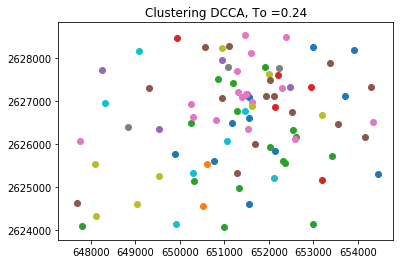

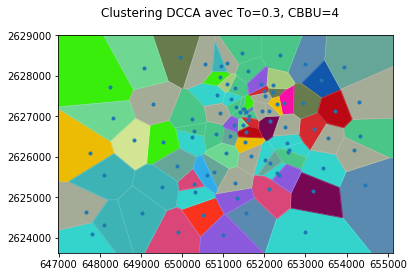

In [99]:
To=0.3
#P,l=apply_DCCA(F,r,To,CBBU)

#T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
#color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.3, CBBU=4")

In [100]:
SMG[To]=(len(clusters)/(k*CBBU))
x,n,y=gain(P,CBBU)
SMGmax[To]=x
SMGmin[To]=n
SMGmoy[To]=y
ecartpos=[]
ecartneg=[]
utilite=[]
for c in P:
    if c!=[]:
        agg=DCCA.aggregationTrafic(c)
        ecart=CBBU-np.max(agg)
        utilite.append(np.max(agg))
        if (ecart >=0):
            ecartpos.append(ecart)
        else:
            ecartneg.append(abs(ecart))
utilite_moy[To]=np.mean(np.array(utilite)) 
if(ecartpos != []):
    souscharge[To]=max(ecartpos)
    souscharge_moy[To]=np.mean(np.array(ecartpos))
else:
    souscharge[To]=0
    souscharge_moy[To]=0
if(ecartneg != []):
    surcharge_moy[To]=np.mean(np.array(ecartneg))
    surcharge[To]=max(ecartneg)
    utilite_max[To]=CBBU+max(ecartneg)
else:
    surcharge_moy[To]=0
    surcharge[To]=0
    utilite_max[To]=CBBU-min(ecartpos)


15


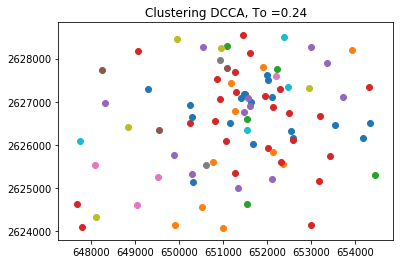

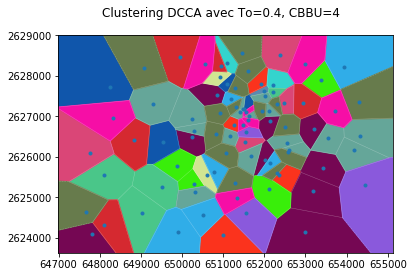

In [101]:
To=0.4
#P,l=apply_DCCA(F,r,To,CBBU)

#T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
#color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.4, CBBU=4")

In [102]:
SMG[To]=(len(clusters)/(k*CBBU))
x,n,y=gain(P,CBBU)
SMGmax[To]=x
SMGmin[To]=n
SMGmoy[To]=y
ecartpos=[]
ecartneg=[]
utilite=[]
for c in P:
    if c!=[]:
        agg=DCCA.aggregationTrafic(c)
        ecart=CBBU-np.max(agg)
        utilite.append(np.max(agg))
        if (ecart >=0):
            ecartpos.append(ecart)
        else:
            ecartneg.append(abs(ecart))
utilite_moy[To]=np.mean(np.array(utilite)) 
if(ecartpos != []):
    souscharge[To]=max(ecartpos)
    souscharge_moy[To]=np.mean(np.array(ecartpos))
else:
    souscharge_moy[To]=0
    souscharge[To]=0
if(ecartneg != []):
    surcharge_moy[To]=np.mean(np.array(ecartneg))
    surcharge[To]=max(ecartneg)
    utilite_max[To]=CBBU+max(ecartneg)
else:
    surcharge_moy[To]=0
    surcharge[To]=0
    utilite_max[To]=CBBU-min(ecartpos)

13


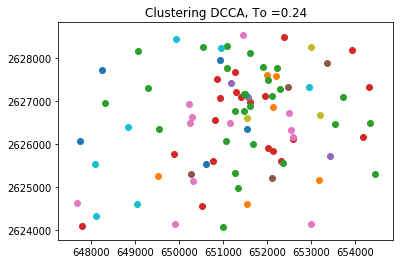

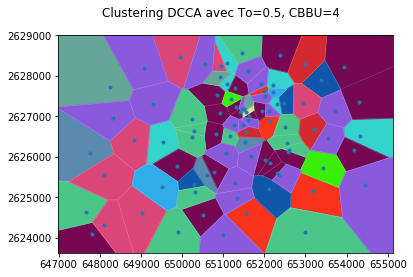

In [103]:
To=0.5
#P,l=apply_DCCA(F,r,To,CBBU)

#T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
#color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.5, CBBU=4")

In [104]:
SMG[To]=(len(clusters)/(k*CBBU))
x,n,y=gain(P,CBBU)
SMGmax[To]=x
SMGmin[To]=n
SMGmoy[To]=y
ecartpos=[]
ecartneg=[]
utilite=[]
for c in P:
    if c!=[]:
        agg=DCCA.aggregationTrafic(c)
        ecart=CBBU-np.max(agg)
        utilite.append(np.max(agg))
        if (ecart >=0):
            ecartpos.append(ecart)
        else:
            ecartneg.append(abs(ecart))
utilite_moy[To]=np.mean(np.array(utilite)) 
if(ecartpos != []):
    souscharge[To]=max(ecartpos)
    souscharge_moy[To]=np.mean(np.array(ecartpos))
else:
    souscharge[To]=0
    souscharge_moy[To]=0
if(ecartneg != []):
    surcharge_moy[To]=np.mean(np.array(ecartneg))
    surcharge[To]=max(ecartneg)
    utilite_max[To]=CBBU+max(ecartneg)
else:
    surcharge_moy[To]=0
    surcharge[To]=0
    utilite_max[To]=CBBU-min(ecartpos)

10


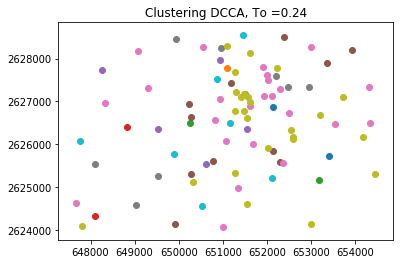

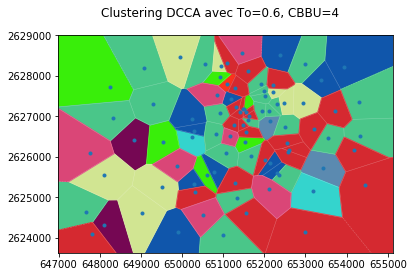

In [105]:
To=0.6
#P,l=apply_DCCA(F,r,To,CBBU)

#T=DCCA.peak_tracking(CBBU,F_norm,r)  
#W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
#color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.6, CBBU=4")

In [106]:
SMG[To]=(len(clusters)/(k*CBBU))
x,n,y=gain(P,CBBU)
SMGmax[To]=x
SMGmin[To]=n
SMGmoy[To]=y
ecartpos=[]
ecartneg=[]
utilite=[]
for c in P:
    if c!=[]:
        agg=DCCA.aggregationTrafic(c)
        ecart=CBBU-np.max(agg)
        utilite.append(np.max(agg))
        if (ecart >=0):
            ecartpos.append(ecart)
        else:
            ecartneg.append(abs(ecart))
utilite_moy[To]=np.mean(np.array(utilite)) 
if(ecartpos != []):
    souscharge_moy[To]=np.mean(np.array(ecartpos))
    souscharge[To]=max(ecartpos)
else:
    souscharge_moy[To]=0
    souscharge[To]=0
if(ecartneg != []):
    surcharge_moy[To]=np.mean(np.array(ecartneg))
    surcharge[To]=max(ecartneg)
    utilite_max[To]=CBBU+max(ecartneg)
else:
    surcharge_moy[To]=0
    surcharge[To]=0
    utilite_max[To]=CBBU-min(ecartpos)

8


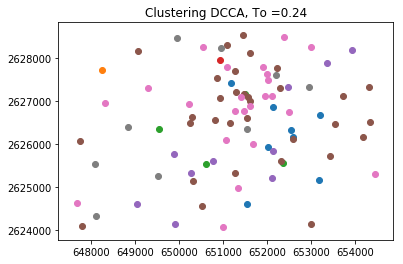

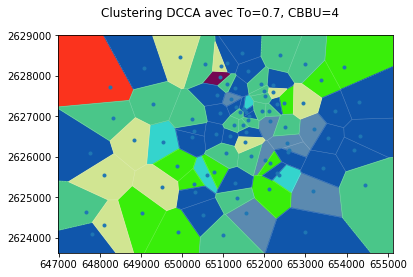

In [107]:
To=0.7
#P,l=apply_DCCA(F,r,To,CBBU)

#T=DCCA.peak_tracking(CBBU,F_norm,r)  
#W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
#color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.7, CBBU=4")

In [108]:
SMG[To]=(len(clusters)/(k*CBBU))
x,n,y=gain(P,CBBU)
SMGmax[To]=x
SMGmin[To]=n
SMGmoy[To]=y
ecartpos=[]
ecartneg=[]
utilite=[]
for c in P:
    if c!=[]:
        agg=DCCA.aggregationTrafic(c)
        ecart=CBBU-np.max(agg)
        utilite.append(np.max(agg))
        if (ecart >=0):
            ecartpos.append(ecart)
        else:
            ecartneg.append(abs(ecart))
utilite_moy[To]=np.mean(np.array(utilite)) 
if(ecartpos != []):
    souscharge_moy[To]=np.mean(np.array(ecartpos))
    souscharge[To]=max(ecartpos)
else:
    souscharge_moy[To]=0
    souscharge[To]=0
if(ecartneg != []):
    surcharge_moy[To]=np.mean(np.array(ecartneg))
    surcharge[To]=max(ecartneg)
    utilite_max[To]=CBBU+max(ecartneg)
else:
    surcharge_moy[To]=0
    surcharge[To]=0
    utilite_max[To]=CBBU-min(ecartpos)



7


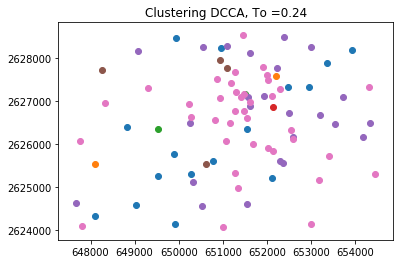

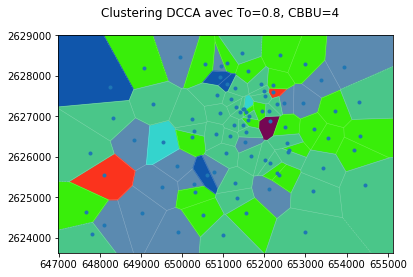

In [109]:
To=0.8
#P,l=apply_DCCA(F,r,To,CBBU)

#T=DCCA.peak_tracking(CBBU,F_norm,r)  
#W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
#color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.8, CBBU=4")

In [110]:
SMG[To]=(len(clusters)/(k*CBBU))
x,n,y=gain(P,CBBU)
SMGmax[To]=x
SMGmin[To]=n
SMGmoy[To]=y
ecartpos=[]
ecartneg=[]
utilite=[]
for c in P:
    if c!=[]:
        agg=DCCA.aggregationTrafic(c)
        ecart=CBBU-np.max(agg)
        utilite.append(np.max(agg))
        if (ecart >=0):
            ecartpos.append(ecart)
        else:
            ecartneg.append(abs(ecart))
utilite_moy[To]=np.mean(np.array(utilite)) 
if(ecartpos != []):
    souscharge_moy[To]=np.mean(np.array(ecartpos))
    souscharge[To]=max(ecartpos)
else:
    souscharge_moy[To]=0
    souscharge[To]=0
if(ecartneg != []):
    surcharge_moy[To]=np.mean(np.array(ecartneg))
    surcharge[To]=max(ecartneg)
    utilite_max[To]=CBBU+max(ecartneg)
else:
    surcharge_moy[To]=0
    surcharge[To]=0
    utilite_max[To]=CBBU-min(ecartpos)



6


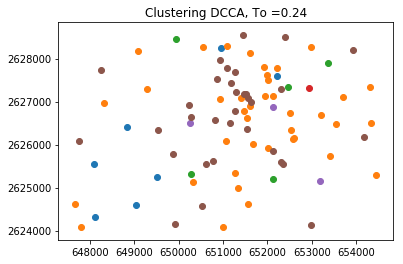

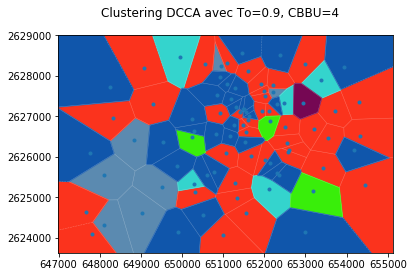

In [111]:
To=0.9
#P,l=apply_DCCA(F,r,To,CBBU)

#T=DCCA.peak_tracking(CBBU,F_norm,r)  
#W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
#color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.9, CBBU=4")

In [112]:
SMG[To]=(len(clusters)/(k*CBBU))
x,n,y=gain(P,CBBU)
SMGmax[To]=x
SMGmin[To]=n
SMGmoy[To]=y
ecartpos=[]
ecartneg=[]
utilite=[]
for c in P:
    if c!=[]:
        agg=DCCA.aggregationTrafic(c)
        ecart=CBBU-np.max(agg)
        utilite.append(np.max(agg))
        if (ecart >=0):
            ecartpos.append(ecart)
        else:
            ecartneg.append(abs(ecart))
utilite_moy[To]=np.mean(np.array(utilite)) 
if(ecartpos != []):
    souscharge_moy[To]=np.mean(np.array(ecartpos))
    souscharge[To]=max(ecartpos)
else:
    souscharge_moy[To]=0
    souscharge[To]=0
if(ecartneg != []):
    surcharge_moy[To]=np.mean(np.array(ecartneg))
    surcharge[To]=max(ecartneg)
    utilite_max[To]=CBBU+max(ecartneg)
else:
    surcharge_moy[To]=0
    surcharge[To]=0
    utilite_max[To]=CBBU-min(ecartpos)



5


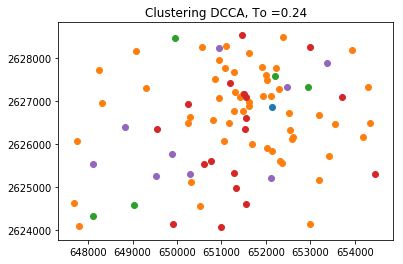

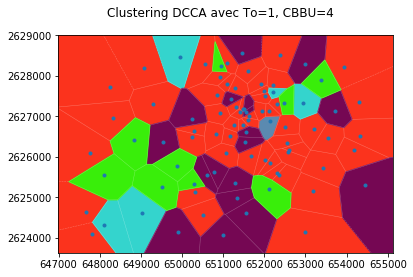

In [113]:
To=1
#P,l=apply_DCCA(F,r,To,CBBU)

#T=DCCA.peak_tracking(CBBU,F_norm,r)  
#W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
#color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=1, CBBU=4")

In [114]:
SMG[To]=(len(clusters)/(k*CBBU))
x,n,y=gain(P,CBBU)
SMGmax[To]=x
SMGmin[To]=n
SMGmoy[To]=y
ecartpos=[]
ecartneg=[]
utilite=[]
for c in P:
    if c!=[]:
        agg=DCCA.aggregationTrafic(c)
        ecart=CBBU-np.max(agg)
        utilite.append(np.max(agg))
        if (ecart >=0):
            ecartpos.append(ecart)
        else:
            ecartneg.append(abs(ecart))
utilite_moy[To]=np.mean(np.array(utilite)) 
if(ecartpos != []):
    souscharge_moy[To]=np.mean(np.array(ecartpos))
    souscharge[To]=max(ecartpos)
else:
    souscharge_moy[To]=0
    souscharge[To]=0
if(ecartneg != []):
    surcharge_moy[To]=np.mean(np.array(ecartneg))
    surcharge[To]=max(ecartneg)
    utilite_max[To]=CBBU+max(ecartneg)
else:
    surcharge_moy[To]=0
    surcharge[To]=0
    utilite_max[To]=CBBU-min(ecartpos)

print(SMG,surcharge,souscharge)

{0.1: 0.38596491228070173, 0.2: 0.6875, 0.3: 1.0476190476190477, 0.4: 1.4666666666666666, 0.5: 1.6923076923076923, 0.6: 2.2, 0.7: 2.75, 0.8: 3.142857142857143, 0.9: 3.6666666666666665, 1: 4.4} {0.1: 0, 0.2: 0, 0.3: 0, 0.4: 0, 0.5: 0, 0.6: 0.7621129148521808, 0.7: 2.76197540295337, 0.8: 3.1343263751570287, 0.9: 3.108123941319402, 1: 7.299966294373855} {0.1: 4.0, 0.2: 4.0, 0.3: 3.8034424688128583, 0.4: 4.0, 0.5: 3.862214667169674, 0.6: 3.560672887856688, 0.7: 3.9065138079009696, 0.8: 3.920380998275803, 0.9: 3.7397819148964384, 1: 3.5420830076357013}


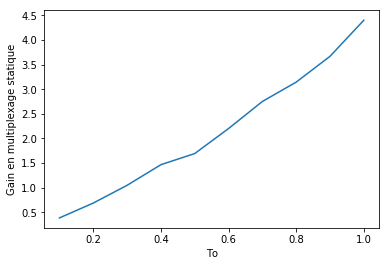

In [115]:
plt.plot(SMG.keys(),SMG.values())
plt.ylabel("Gain en multiplexage statique")
plt.xlabel("To")
plt.show()

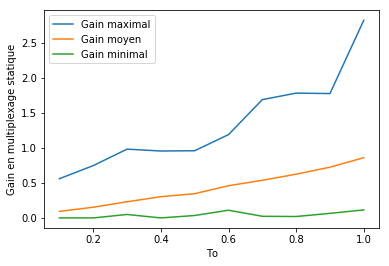

In [116]:
x,n,y=gain(P,CBBU)
plt.plot(SMGmax.keys(),SMGmax.values(),label="Gain maximal")
plt.plot(SMGmoy.keys(),SMGmoy.values(),label="Gain moyen")
plt.plot(SMGmin.keys(),SMGmin.values(),label="Gain minimal")
plt.legend()
plt.ylabel("Gain en multiplexage statique")
plt.xlabel("To")
plt.show()

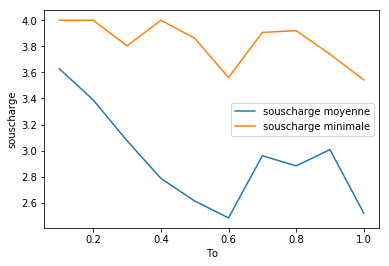

In [117]:
plt.plot(souscharge_moy.keys(),souscharge_moy.values(),label="souscharge moyenne")
plt.plot(souscharge.keys(),souscharge.values(),label="souscharge minimale")
plt.ylabel("souscharge")
plt.xlabel("To")
plt.legend()
plt.show()

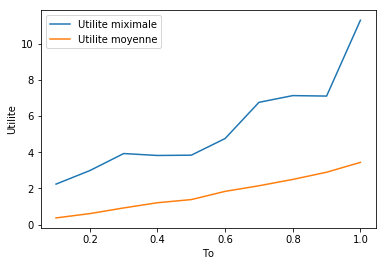

In [120]:
plt.plot(utilite_max.keys(),utilite_max.values(),label="Utilite miximale")
plt.plot(utilite_moy.keys(),utilite_moy.values(),label="Utilite moyenne")
plt.legend()
plt.ylabel("Utilite")
plt.xlabel("To")
plt.show()

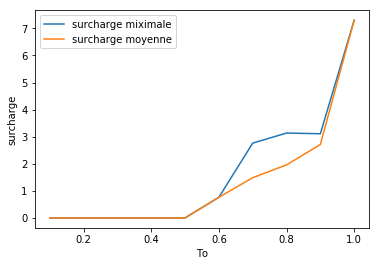

In [119]:
plt.plot(surcharge.keys(),surcharge.values(),label="surcharge miximale")
plt.plot(surcharge_moy.keys(),surcharge_moy.values(),label="surcharge moyenne")
plt.ylabel("surcharge")
plt.xlabel("To")
plt.legend()
plt.show()

#### Valeurs de Capacité de la BBU :

In [42]:
def evaluate_CBBU (P,CBBU):
    ecart=[]
    for C in P:
        if (C!=[]):
            traf_arg=DCCA.aggregationTrafic(C)
            ecart.append(CBBU-max(traf_arg))
    return ecart

In [43]:
To=0.4
lesmax=[]
lesmin=[]
for i in range(1,10):
    CBBU=i
    T=DCCA.peak_tracking(CBBU,F_norm,r)  
    W=DCCA.matriceComplementarite(r,CBBU,To)
    P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
    e=evaluate_CBBU(P,CBBU)
    lesmax.append(max(e))
    lesmin.append(min(e))

[-3.77414398694678, -2.475367265449889, -1.520707962002609, -1.441988406904736, 0.362085747160358, 0.8470517839737726, 2.221386875159193, 2.399053040123423, 4.125950586873012]


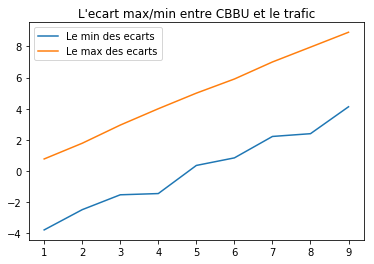

In [44]:
print(lesmin)
x=list(np.arange(1,10))
plt.title("L'ecart max/min entre CBBU et le trafic")
plt.plot(x, lesmin, label="Le min des ecarts ")
plt.plot(x, lesmax, label="Le max des ecarts")
plt.legend()
plt.show()

## Clustering Par Tranche :

## Jour de semaine:

In [286]:
#F,Fup,r=generate_day_matrix("2019-05-21")

In [107]:
F_wd,Fup_wd,r_wd=generate_day_matrix("2019-05-19")

In [108]:
trafic_max1=max(np.max(F),np.max(F_wd))*0.75
trafic_min1=min(np.min(F),np.min(F_wd))*0.75
print(trafic_max1,trafic_min1)
print((np.max(F),np.max(F_wd)))

3261172247.425289 0.0
(4348229663.233719, 1648823168.9081848)


In [109]:
F_norm=DCCA.normalize_trafic(F,trafic_max1,trafic_min1)


### 1. Création de Timespans

In [110]:
F1=F_norm[:,0:8]
F2=F_norm[:,8:12]
F3=F_norm[:,12:16]
F4=F_norm[:,16:23]
print(np.shape(F1))

(88, 8)


### 2. Choix de CBBU

In [111]:
To=0.4
lesmax=[]
lesmin=[]
for i in range(1,11):
    CBBU=i
    T=DCCA.peak_tracking(CBBU,F_norm,r)  
    W=DCCA.matriceComplementarite(r,CBBU,To)
    P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
    e=evaluate_CBBU(P,CBBU)
    lesmax.append(max(e))
    lesmin.append(min(e))


[-3.7314580615354, -3.8041468317603115, -2.080993018881162, -0.022141085439107755, 0.15850750215006038, 1.010717135915045, 2.8716660777329013, 2.6767463572300203, 3.7002203021784936, 5.7465265292873955]


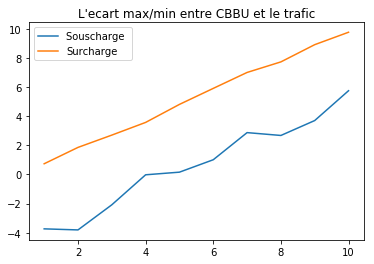

In [112]:
print(lesmin)
x=list(np.arange(1,11))
plt.title("L'ecart max/min entre CBBU et le trafic")
plt.plot(x, lesmin, label="Souscharge ")
plt.plot(x, lesmax, label="Surcharge")
plt.legend()
plt.show()

Le min des écarts n'evoule pas en monotonie car on exécute DCCA à chaque fois qui génère des clusters différents à chaque exécution et donc le trafic aggregé diffère.

### 3. Clustering

In [142]:
SMG_semaine={}
surcharge_semaine={}
souscharge_semaine={}
utilite_max_semaine={}

15


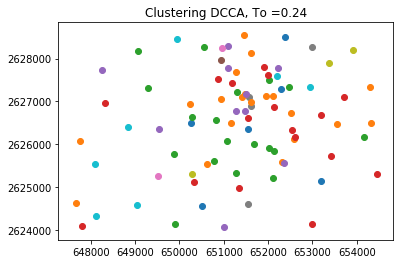

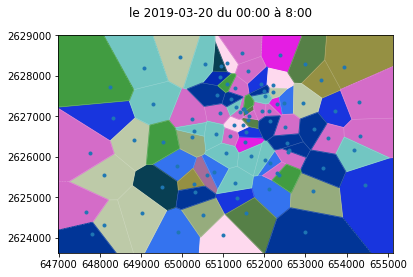

In [143]:
To=0.4
CBBU=5
#P,l=apply_DCCA(F,r,To,CBBU)
for i in range(len(r)):
        r[i].setTrafic(F1[i])

T=DCCA.peak_tracking(CBBU,F1,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F1,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
affichage_vor(clusters,coord,color, "le 2019-03-20 du 00:00 à 8:00")

In [144]:
h="00:00"
SMG_semaine[h]=(len(clusters)/(k*CBBU))
ecartpos=[]
ecartneg=[]
for c in P:
    if c!=[]:
        agg=DCCA.aggregationTrafic(c)
        ecart=CBBU-np.max(agg)
        if (ecart >=0):
            ecartpos.append(ecart)
        else:
            ecartneg.append(abs(ecart))
if(ecartpos != []):
    souscharge_semaine[h]=max(ecartpos)
    
else:
    souscharge_semaine[h]=0
if(ecartneg != []):
    surcharge_semaine[h]=max(ecartneg)
    utilite_max_semaine[h]=CBBU+max(ecartneg)
else:
    surcharge_semaine[h]=0
    utilite_max_semaine[h]=CBBU-min(ecartpos)

17


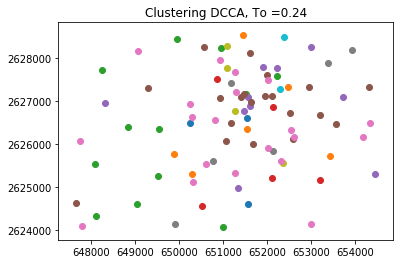

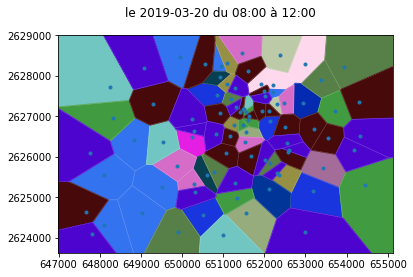

In [145]:
for i in range(len(r)):
    r[i].setTrafic(F2[i])

T=DCCA.peak_tracking(CBBU,F2,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F2,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
affichage_vor(clusters,coord,color, "le 2019-03-20 du 08:00 à 12:00")

In [146]:
h="08:00"
SMG_semaine[h]=(len(clusters)/(k*CBBU))
ecartpos=[]
ecartneg=[]
for c in P:
    if c!=[]:
        agg=DCCA.aggregationTrafic(c)
        ecart=CBBU-np.max(agg)
        if (ecart >=0):
            ecartpos.append(ecart)
        else:
            ecartneg.append(abs(ecart))
if(ecartpos != []):
    souscharge_semaine[h]=max(ecartpos)
    
else:
    souscharge_semaine[h]=0
if(ecartneg != []):
    surcharge_semaine[h]=max(ecartneg)
    utilite_max_semaine[h]=CBBU+max(ecartneg)
else:
    surcharge_semaine[h]=0
    utilite_max_semaine[h]=CBBU-min(ecartpos)

13


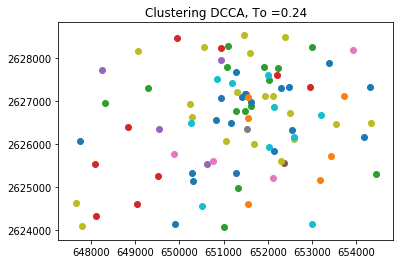

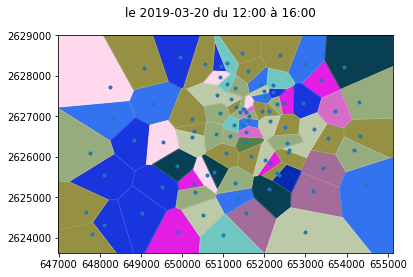

In [147]:
for i in range(len(r)):
    r[i].setTrafic(F3[i])

T=DCCA.peak_tracking(CBBU,F3,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F3,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
affichage_vor(clusters,coord,color, "le 2019-03-20 du 12:00 à 16:00")

In [148]:
h="12:00"
SMG_semaine[h]=(len(clusters)/(k*CBBU))
ecartpos=[]
ecartneg=[]
for c in P:
    if c!=[]:
        agg=DCCA.aggregationTrafic(c)
        ecart=CBBU-np.max(agg)
        if (ecart >=0):
            ecartpos.append(ecart)
        else:
            ecartneg.append(abs(ecart))
if(ecartpos != []):
    souscharge_semaine[h]=max(ecartpos)
    
else:
    souscharge_semaine[h]=0
if(ecartneg != []):
    surcharge_semaine[h]=max(ecartneg)
    utilite_max_semaine[h]=CBBU+max(ecartneg)
else:
    surcharge_semaine[h]=0
    utilite_max_semaine[h]=CBBU-min(ecartpos)

15


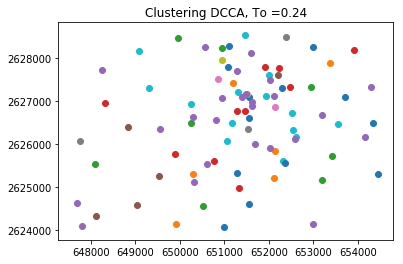

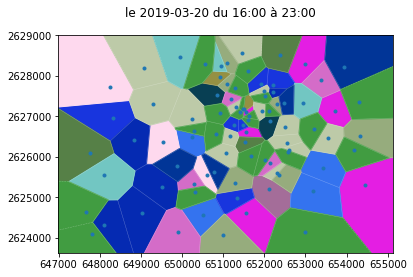

In [149]:
for i in range(len(r)):
    r[i].setTrafic(F4[i])

T=DCCA.peak_tracking(CBBU,F4,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F4,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
affichage_vor(clusters,coord,color, "le 2019-03-20 du 16:00 à 23:00")

In [150]:
h="16:00"
SMG_semaine[h]=(len(clusters)/(k*CBBU))
ecartpos=[]
ecartneg=[]
for c in P:
    if c!=[]:
        agg=DCCA.aggregationTrafic(c)
        ecart=CBBU-np.max(agg)
        if (ecart >=0):
            ecartpos.append(ecart)
        else:
            ecartneg.append(abs(ecart))
if(ecartpos != []):
    souscharge_semaine[h]=max(ecartpos)
    
else:
    souscharge_semaine[h]=0
if(ecartneg != []):
    surcharge_semaine[h]=max(ecartneg)
    utilite_max_semaine[h]=CBBU+max(ecartneg)
else:
    surcharge_semaine[h]=0
    utilite_max_semaine[h]=CBBU-min(ecartpos)

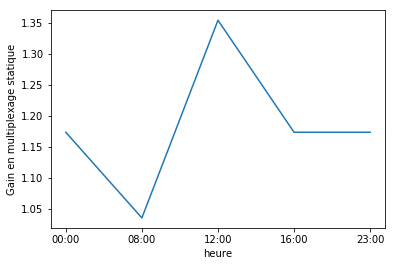

In [151]:
x=list(SMG_semaine.keys())+["23:00"]
y=list(SMG_semaine.values())+[SMG_semaine["00:00"]]
plt.plot(x,y)
plt.ylabel("Gain en multiplexage statique")
plt.xlabel("heure")
plt.show()

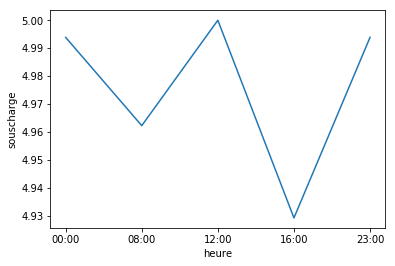

In [152]:
plt.plot(list(souscharge_semaine.keys())+["23:00"],list(souscharge_semaine.values())+[souscharge_semaine["00:00"]])
plt.ylabel("souscharge")
plt.xlabel("heure")
plt.show()

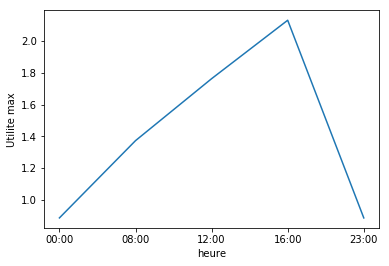

In [153]:
plt.plot(list(utilite_max_semaine.keys())+["23:00"],list(utilite_max_semaine.values())+[utilite_max_semaine["00:00"]])
plt.ylabel("Utilite max")
plt.xlabel("heure")
plt.show()

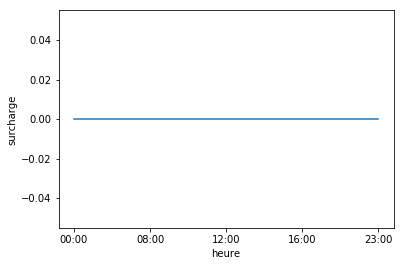

In [154]:
plt.plot(list(surcharge_semaine.keys())+["23:00"],list(surcharge_semaine.values())+[surcharge_semaine["00:00"]])
plt.ylabel("surcharge")
plt.xlabel("heure")
plt.show()

## Weekend

In [126]:
#F,Fup,r=generate_day_matrix("2019-03-31")
F_norm=DCCA.normalize_trafic(F_wd,trafic_max1,trafic_min1)
"""
for i in range(len(r_wd)):
        r_wd[i].setTrafic(F_norm[i])
"""

'\nfor i in range(len(r_wd)):\n        r_wd[i].setTrafic(F_norm[i])\n'

In [127]:
F1=F_norm[:,0:8]
F2=F_norm[:,8:12]
F3=F_norm[:,12:16]
F4=F_norm[:,16:23]
print(np.shape(F1))

(88, 8)


In [128]:
SMG_weekend={}
surcharge_weekend={}
souscharge_weekend={}
utilite_max_weekend={}

16


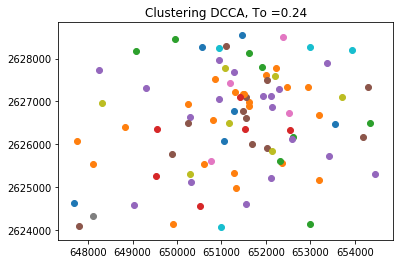

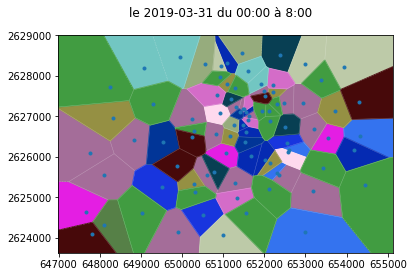

In [129]:
CBBU=4
To=0.4
#P,l=apply_DCCA(F,r,To,CBBU)
for i in range(len(r_wd)):
    r_wd[i].setTrafic(F1[i])
T=DCCA.peak_tracking(CBBU,F1,r_wd)  
W=DCCA.matriceComplementarite(r_wd,CBBU,To)
P,l=DCCA.iterative_DCCA (r_wd,F1,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
affichage_vor(clusters,coord,color, "le 2019-03-31 du 00:00 à 8:00")

In [130]:
h="00:00"
SMG_weekend[h]=(len(clusters)/(k*CBBU))
ecartpos=[]
ecartneg=[]
for c in P:
    if c!=[]:
        agg=DCCA.aggregationTrafic(c)
        ecart=CBBU-np.max(agg)
        if (ecart >=0):
            ecartpos.append(ecart)
        else:
            ecartneg.append(abs(ecart))
if(ecartpos != []):
    souscharge_weekend[h]=max(ecartpos)
    
else:
    souscharge_weekend[h]=0
if(ecartneg != []):
    surcharge_weekend[h]=max(ecartneg)
    utilite_max_weekend[h]=CBBU+max(ecartneg)
else:
    surcharge_weekend[h]=0
    utilite_max_weekend[h]=CBBU-min(ecartpos)

15


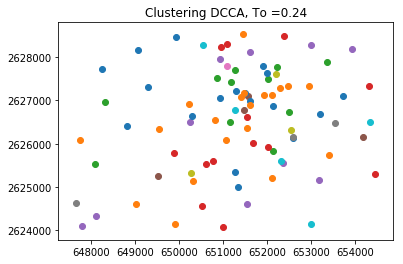

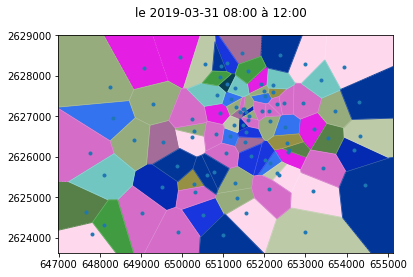

In [131]:
for i in range(len(r_wd)):
    r_wd[i].setTrafic(F2[i])
T=DCCA.peak_tracking(CBBU,F2,r_wd)  
W=DCCA.matriceComplementarite(r_wd,CBBU,To)
P,l=DCCA.iterative_DCCA (r_wd,F2,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
affichage_vor(clusters,coord,color, "le 2019-03-31 08:00 à 12:00")

In [132]:
h="08:00"
SMG_weekend[h]=(len(clusters)/(k*CBBU))
ecartpos=[]
ecartneg=[]
for c in P:
    if c!=[]:
        agg=DCCA.aggregationTrafic(c)
        ecart=CBBU-np.max(agg)
        if (ecart >=0):
            ecartpos.append(ecart)
        else:
            ecartneg.append(abs(ecart))
if(ecartpos != []):
    souscharge_weekend[h]=max(ecartpos)
    
else:
    souscharge_weekend[h]=0
if(ecartneg != []):
    surcharge_weekend[h]=max(ecartneg)
    utilite_max_weekend[h]=CBBU+max(ecartneg)
else:
    surcharge_weekend[h]=0
    utilite_max_weekend[h]=CBBU-min(ecartpos)

14


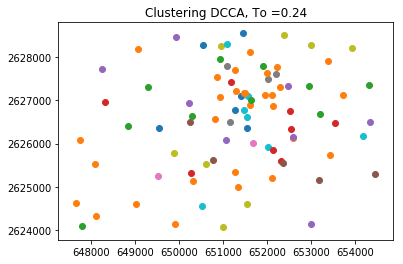

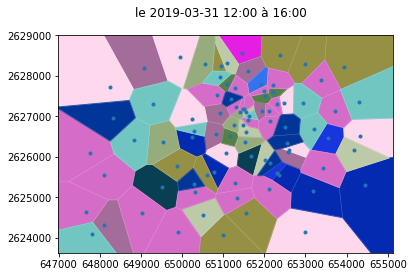

In [133]:
for i in range(len(r_wd)):
    r_wd[i].setTrafic(F3[i])
T=DCCA.peak_tracking(CBBU,F3,r_wd)  
W=DCCA.matriceComplementarite(r_wd,CBBU,To)
P,l=DCCA.iterative_DCCA (r_wd,F3,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
affichage_vor(clusters,coord,color, "le 2019-03-31 12:00 à 16:00")

In [134]:
h="12:00"
SMG_weekend[h]=(len(clusters)/(k*CBBU))
ecartpos=[]
ecartneg=[]
for c in P:
    if c!=[]:
        agg=DCCA.aggregationTrafic(c)
        ecart=CBBU-np.max(agg)
        if (ecart >=0):
            ecartpos.append(ecart)
        else:
            ecartneg.append(abs(ecart))
if(ecartpos != []):
    souscharge_weekend[h]=max(ecartpos)
    
else:
    souscharge_weekend[h]=0
if(ecartneg != []):
    surcharge_weekend[h]=max(ecartneg)
    utilite_max_weekend[h]=CBBU+max(ecartneg)
else:
    surcharge_weekend[h]=0
    utilite_max_weekend[h]=CBBU-min(ecartpos)

18


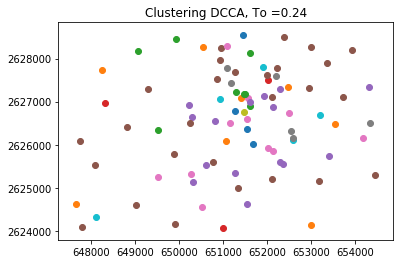

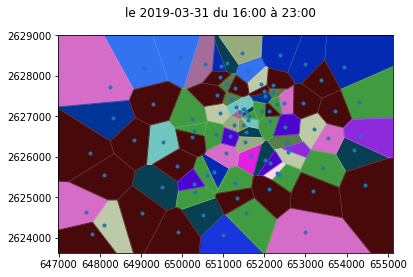

In [135]:
for i in range(len(r_wd)):
    r_wd[i].setTrafic(F4[i])
T=DCCA.peak_tracking(CBBU,F4,r_wd)  
W=DCCA.matriceComplementarite(r_wd,CBBU,To)
P,l=DCCA.iterative_DCCA (r_wd,F4,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
affichage_vor(clusters,coord,color, "le 2019-03-31 du 16:00 à 23:00")

In [136]:
h="16:00"
SMG_weekend[h]=(len(clusters)/(k*CBBU))
ecartpos=[]
ecartneg=[]
for c in P:
    if c!=[]:
        agg=DCCA.aggregationTrafic(c)
        ecart=CBBU-np.max(agg)
        if (ecart >=0):
            ecartpos.append(ecart)
        else:
            ecartneg.append(abs(ecart))
if(ecartpos != []):
    souscharge_weekend[h]=max(ecartpos)
    
else:
    souscharge_weekend[h]=0
if(ecartneg != []):
    surcharge_weekend[h]=max(ecartneg)
    utilite_max_weekend[h]=CBBU+max(ecartneg)
else:
    surcharge_weekend[h]=0
    utilite_max_weekend[h]=CBBU-min(ecartpos)

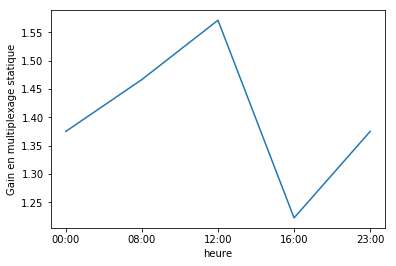

In [137]:
plt.plot(list(SMG_weekend.keys())+["23:00"],list(SMG_weekend.values())+[SMG_weekend["00:00"]])
plt.ylabel("Gain en multiplexage statique")
plt.xlabel("heure")
plt.show()

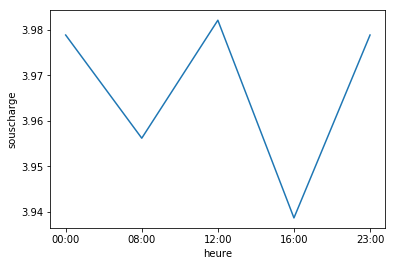

In [138]:
plt.plot(list(souscharge_weekend.keys())+["23:00"],list(souscharge_weekend.values())+[souscharge_weekend["00:00"]])
plt.ylabel("souscharge")
plt.xlabel("heure")
plt.show()

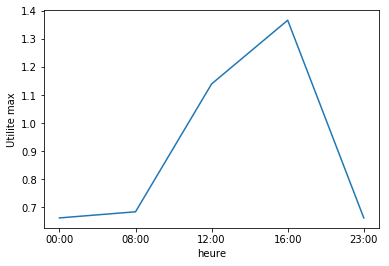

In [139]:
plt.plot(list(utilite_max_weekend.keys())+["23:00"],list(utilite_max_weekend.values())+[utilite_max_weekend["00:00"]])
plt.ylabel("Utilite max")
plt.xlabel("heure")
plt.show()

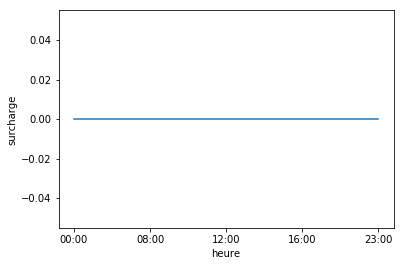

In [140]:
plt.plot(list(surcharge_weekend.keys())+["23:00"],list(surcharge_weekend.values())+[surcharge_weekend["00:00"]])
plt.ylabel("surcharge")
plt.xlabel("heure")
plt.show()

In [141]:
trafic_max2=trafic_max*0.5
trafic_min2=trafic_min*0.5
print(trafic_max1,trafic_min1)
print((np.max(F),np.max(F_wd)))
F_norm=DCCA.normalize_trafic(F,trafic_max2,trafic_min2)
F1=F_norm[:,0:8]
F2=F_norm[:,8:12]
F3=F_norm[:,12:16]
F4=F_norm[:,16:23]
print(np.shape(F1))

3261172247.425289 0.0
(4348229663.233719, 1648823168.9081848)
(88, 8)
